# SEA-POL low-level gridded rain rate

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/gridded_rainrate/PICCOLO_gridded_rainrate_all.nc')
seapol

<xarray.Dataset> Size: 26GB
Dimensions:          (time: 4447, Y: 491, X: 491)
Coordinates:
  * X                (X) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
  * Y                (Y) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
    latitude         (time, Y, X) float32 4GB ...
    longitude        (time, Y, X) float32 4GB ...
  * time             (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192...
Data variables:
    DBZ              (time, Y, X) float32 4GB ...
    HID              (time, Y, X) float32 4GB ...
    RAINRATE         (time, Y, X) float32 4GB ...
    elevation_angle  (time, Y, X) float32 4GB ...
    grid_mapping     int32 4B ...
    heading          (time) float32 18kB ...
    start_time       (time) datetime64[ns] 36kB ...
    stop_time        (time) datetime64[ns] 36kB ...
Attributes:
    Conventions:  CF-1.6
    history:      Thu Feb 27 13:05:33 2025: ncrcat gridded_rainrate_20240816_...
    institution:  CSU
    source:       SEAPOL
    title:        Gridded Radar Data v1.0
    comment:      Level 4 Gridded Radar Data
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...

In [3]:
# Mask out missing data (-32769 = no data possible)
rainrate = seapol.RAINRATE.where(seapol.RAINRATE >=-30000, np.nan)
dbz = seapol.DBZ.where(seapol.DBZ >=-30000, np.nan)

In [4]:

# Change -9999 missing data to zeros (data possible but removed = "not raining" though technically could be below beam) 
rainrate2 = rainrate.where(rainrate != -9999., 0)
#dbz2 = dbz
dbz2 = dbz.where(rainrate != -9999., np.nan)

In [5]:
# Also mask out seemingly bad data (rainrate > 10000 mm/h) or > 1000 mm/h --> set to zero (like saying there is no echo)
rainrate3 = rainrate2.where((rainrate2 <= 10000) | (rainrate2.isnull()), 0) # keep nans
dbz3 = dbz2.where((rainrate2 <= 10000) | (dbz2.isnull()), np.nan)
rainrate4 = rainrate3.where((rainrate3 <= 1000) | (rainrate2.isnull()), 0)
dbz4 = dbz3.where((rainrate3 <= 1000) | (dbz3.isnull()), np.nan)

In [8]:
# Mask out land
# prepare temporary plot and create mask from rasterized map
proj = {'projection': ccrs.PlateCarree()}
fig, ax = plt.subplots(figsize=(491/100, 491/100), dpi=100, subplot_kw=proj)
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
ax.set_frame_on(False)

ax.set_xlim(seapol.longitude[1547,0,:].min(), seapol.longitude[1547,0,:].max())
ax.set_ylim(seapol.latitude[1547,:,0].min(), seapol.latitude[1547,:,0].max())

ax.add_feature(cartopy.feature.LAND, facecolor='black')
fig.canvas.draw()
mask = np.asarray(fig.canvas.buffer_rgba())
plt.close(fig)

mask = mask[:, :, :3].mean(axis=2)  # Convert RGBA to grayscale
mask = np.transpose(mask)
mask = np.rot90(mask)
rainrate_lm  = np.where(mask>0, seapol.RAINRATE[1547,:,:], np.nan)
dbz_lm = np.where(mask>0, seapol.DBZ[1547,:,:], np.nan)

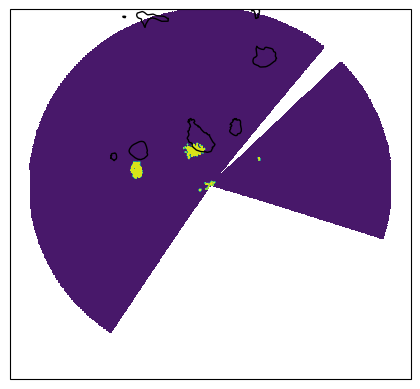

In [11]:

fig, ax = plt.subplots(subplot_kw=proj)
ax.contourf(seapol.longitude[1547,:,:], seapol.latitude[1547,:,:],dbz_lm, 60)
ax.contourf(seapol.longitude[1547,:,:], seapol.latitude[1547,:,:],seapol.DBZ[1547,:,:])
ax.coastlines()
plt.show()

Text(0.5, 1.0, 'Mosaic of SEA-POL long-range scans every 6 hours')

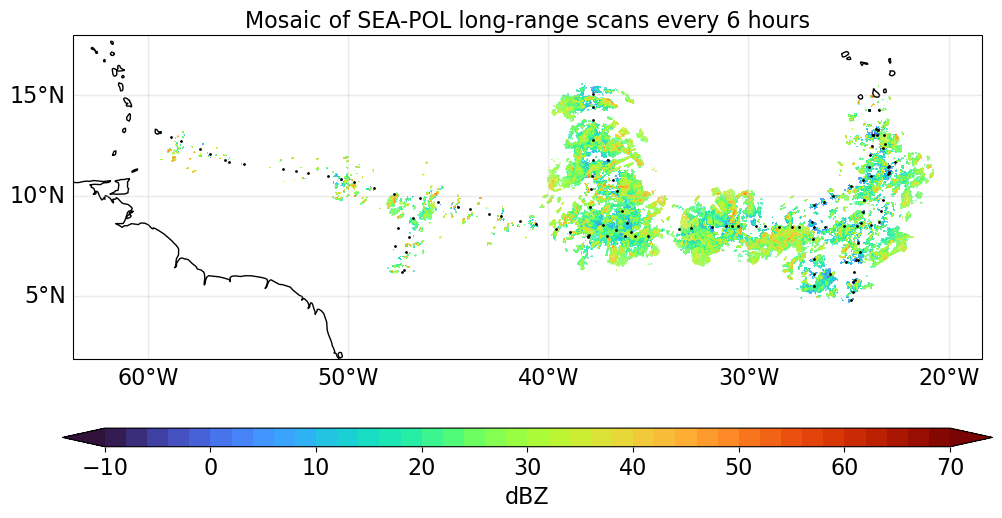

In [29]:
fig, ax = plt.subplots(figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

im = ax.contourf(seapol.longitude[60,:,:], seapol.latitude[60,:,:],dbz4[60,:,:],vmin=-10, vmax=70, levels=np.linspace(-10,70,41), cmap='turbo', extend='both')
plt.plot(seapol.longitude[60,245,245], seapol.latitude[60,245,245], 'ko', markersize=1)
interval = 36 #interval of time steps to plot (72 -> 12 hours)
for n in range(0, 120):
    ax.contourf(seapol.longitude[60+interval*n,:,:], seapol.latitude[60+interval*n,:,:],dbz4[60+interval*n,:,:],vmin=-10, vmax=70, levels=np.linspace(-10,70,41), cmap='turbo', extend='both',alpha=0.5)
    plt.plot(seapol.longitude[60+interval*n,245,245], seapol.latitude[60+interval*n,245,245], 'ko', markersize=1)
ax.contourf(seapol.longitude[-1,:,:], seapol.latitude[-1,:,:],dbz4[-1,:,:],vmin=-10, vmax=70, levels=np.linspace(-10,70,41), cmap='turbo', extend='both',alpha=0.5)
plt.plot(seapol.longitude[-1,245,245], seapol.latitude[-1,245,245], 'ko', markersize=1)

#add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',aspect=50)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('dBZ', fontsize=16)
ax.coastlines()

plt.title('Mosaic of SEA-POL long-range scans every 6 hours', fontsize=16)

In [30]:
#Check for bad data

ihigh = np.where(rainrate2 > 1000)
ihigh

(array([   9,    9,   10,   12,   32,   32,   33,   39,   39,   39,   39,
          42,   42,   42,   42,   42,   44,   47,   47,  124,  813, 1532,
        1532, 1532, 1532, 1547, 1547, 1547, 1547, 1547, 1547, 1547, 1548,
        1548, 1549, 1549, 1549, 1549, 1551, 1551, 1551, 1552, 1552, 1553,
        1553, 1553, 1553, 1554, 4319, 4319, 4359, 4395, 4397, 4397]),
 array([265, 265, 267, 265, 323, 324, 326, 171, 172, 172, 174, 288, 292,
        293, 296, 301, 306, 309, 314, 264, 233, 301, 301, 302, 302, 261,
        262, 262, 263, 263, 264, 272, 258, 259, 284, 287, 288, 289, 254,
        255, 255, 251, 252, 255, 258, 259, 260, 272, 239, 239, 244, 244,
        246, 246]),
 array([249, 250, 247, 271, 260, 260, 260, 289, 289, 290, 293, 280, 277,
        277, 276, 275, 271, 269, 266, 252, 225, 139, 140, 139, 140, 151,
        150, 151, 150, 151, 151, 147, 152, 152, 230, 234, 234, 230, 154,
        153, 154, 154, 154, 152, 151, 151, 150, 218, 211, 212, 241, 240,
        230, 231]))

In [31]:
#Print out the bad data

for i in range(len(ihigh[0])):
    print(f"Rainrate: {rainrate2[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values} mm/h at time {seapol.time[ihigh[0][i]].values} and lat/lon {seapol.latitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}, {seapol.longitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}")



Rainrate: 1021.3322143554688 mm/h at time 2024-08-16T09:40:44.904999936 and lat/lon 16.817970275878906, -24.97370719909668
Rainrate: 1040.5140380859375 mm/h at time 2024-08-16T09:40:44.904999936 and lat/lon 16.817968368530273, -24.964324951171875
Rainrate: 1122.972900390625 mm/h at time 2024-08-16T09:50:45.708000000 and lat/lon 16.80978012084961, -24.980283737182617
Rainrate: 1129.2977294921875 mm/h at time 2024-08-16T10:10:45.495000064 and lat/lon 16.73886489868164, -24.73084259033203
Rainrate: 1081.5631103515625 mm/h at time 2024-08-16T13:50:44.878000128 and lat/lon 16.67772102355957, -24.562305450439453
Rainrate: 1054.5994873046875 mm/h at time 2024-08-16T13:50:44.878000128 and lat/lon 16.686756134033203, -24.562297821044922
Rainrate: 1059.40185546875 mm/h at time 2024-08-16T14:00:45.525000192 and lat/lon 16.67873764038086, -24.5502872467041
Rainrate: 1429.0140380859375 mm/h at time 2024-08-16T15:00:48.927000064 and lat/lon 15.09607982635498, -24.197509765625
Rainrate: 1732.39160156

# Take spatial averages

In [6]:
#Spatial mean over 245 km x 245 km
rain245 = rainrate4.mean(dim=('X','Y'),skipna=True)

#Spatial mean over 120 km x 120 km
rain120 = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 60 km x 60 km
rain60 = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 12 km x 12 km
rain12 = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean within 1 km
rain1 = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).mean(dim=('X','Y'),skipna=True)


In [8]:
# Find indices of known bad data times (to mask out)
# Search times
time1a= np.datetime64('2024-08-16T00:00:00') #CV islands
time1b = np.datetime64('2024-08-17T02:00:00') #CV islands
time2a = np.datetime64('2024-08-27T22:00:00') #Praia
time2b = np.datetime64('2024-08-28T07:00:00') #Praia
time3 = np.datetime64('2024-09-21T18:11:12.288000000') #zeros are NaNs instead

#Find indices for start and end times
index1a = np.abs(pd.to_datetime(rain245.time) - time1a).argmin()
index1b = np.abs(pd.to_datetime(rain245.time) - time1b).argmin()
index2a = np.abs(pd.to_datetime(rain245.time) - time2a).argmin()
index2b = np.abs(pd.to_datetime(rain245.time) - time2b).argmin()
index3 = np.abs(pd.to_datetime(rain245.time) - time3).argmin()
print(f"Index for time 1a: {index1a}")
print(f"Index for time 1b: {index1b}")
print(f"Index for time 2a: {index2a}")
print(f"Index for time 2b: {index2b}")
print(f"Index for time 3: {index3}")


#Set bad data to NaN
rain245[index1a:index1b+1] = np.nan
rain245[index2a:index2b+1] = np.nan
rain245[index3] = np.nan
rain120[index1a:index1b+1] = np.nan
rain120[index2a:index2b+1] = np.nan
rain120[index3] = np.nan
rain60[index1a:index1b+1] = np.nan
rain60[index2a:index2b+1] = np.nan
rain60[index3] = np.nan
rain1[index1a:index1b+1] = np.nan
rain1[index2a:index2b+1] = np.nan
rain1[index3] = np.nan



Index for time 1a: 0
Index for time 1b: 69
Index for time 2a: 1502
Index for time 2b: 1555
Index for time 3: 4174


In [7]:
# Conditional mean (only where rainrate > 0)
rain245cond = rainrate4.where(rainrate4>0).mean(dim=('X','Y'),skipna=True)
rain120cond = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).where(rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))>0).mean(dim=('X','Y'),skipna=True)
rain60cond = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).where(rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000))>0).mean(dim=('X','Y'),skipna=True)
rain12cond = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).where(rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000))>0).mean(dim=('X','Y'),skipna=True)
rain1cond = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).where(rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000))>0).mean(dim=('X','Y'),skipna=True)

In [9]:
#set bad data to NaN
rain245cond[index1a:index1b+1] = np.nan
rain245cond[index2a:index2b+1] = np.nan

rain120cond[index1a:index1b+1] = np.nan
rain120cond[index2a:index2b+1] = np.nan

rain60cond[index1a:index1b+1] = np.nan
rain60cond[index2a:index2b+1] = np.nan

rain12cond[index1a:index1b+1] = np.nan
rain12cond[index2a:index2b+1] = np.nan

rain1cond[index1a:index1b+1] = np.nan
rain1cond[index2a:index2b+1] = np.nan



# Write out spatial averages to file

In [10]:
#combine into one dataset
rainrate = xr.Dataset({'rain245_mean': rain245, 'rain120_mean': rain120, 'rain60_mean': rain60, 'rain12_mean': rain12, 'rain1_mean': rain1, 'rain245_int': rain245cond, 'rain120_int': rain120cond, 'rain60_int': rain60cond, 'rain12_int': rain12cond, 'rain1_int': rain1cond})

#add attributes
rainrate.attrs['title'] = 'Spatial mean rainrate from SEA-POL long-range, low-elevation scans'
rainrate.attrs['description'] = 'Spatial means of rainrate from SEA-POL long-range, low-elevation scans at different spatial scales. Mean is the average over all valid data points (including zeros). Int (intensity) is the average over all data points where rainrate > 0.'
rainrate.attrs['source'] = 'SEA-POL Level4a Gridded Rain Rate'
rainrate.attrs['units'] = 'mm/h'

#save to netcdf
rainrate.to_netcdf('/home/awing/orcestra/data/SEA-POL_gridded_rainrate_spatial_means_masked.nc')

rainrate

<xarray.Dataset> Size: 213kB
Dimensions:       (time: 4447)
Coordinates:
  * time          (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192 .....
Data variables:
    rain245_mean  (time) float32 18kB nan nan nan ... 0.03071 0.04999 0.06366
    rain120_mean  (time) float32 18kB nan nan nan ... 0.06709 0.08428 0.08762
    rain60_mean   (time) float32 18kB nan nan nan ... 0.0 9.365e-05 1.192e-05
    rain12_mean   (time) float32 18kB 1.432 4.165 4.203 ... 0.002042 0.000261
    rain1_mean    (time) float32 18kB nan nan nan nan ... 0.0 0.0 0.03672 0.0
    rain245_int   (time) float32 18kB nan nan nan nan ... 8.406 9.14 15.1 10.08
    rain120_int   (time) float32 18kB nan nan nan nan ... 6.593 7.985 11.93 8.99
    rain60_int    (time) float32 18kB nan nan nan nan ... nan nan 0.311 0.02386
    rain12_int    (time) float32 18kB nan nan nan nan ... nan nan 0.311 0.02386
    rain1_int     (time) float32 18kB nan nan nan nan nan ... nan nan 0.3305 nan
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4a Gridded Rain Rate
    units:        mm/h

In [11]:
# Set BP and AP times
BPtime = np.datetime64('2024-08-28T06:00:00')
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexBP = np.abs(pd.to_datetime(seapol.time) - BPtime).argmin()
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

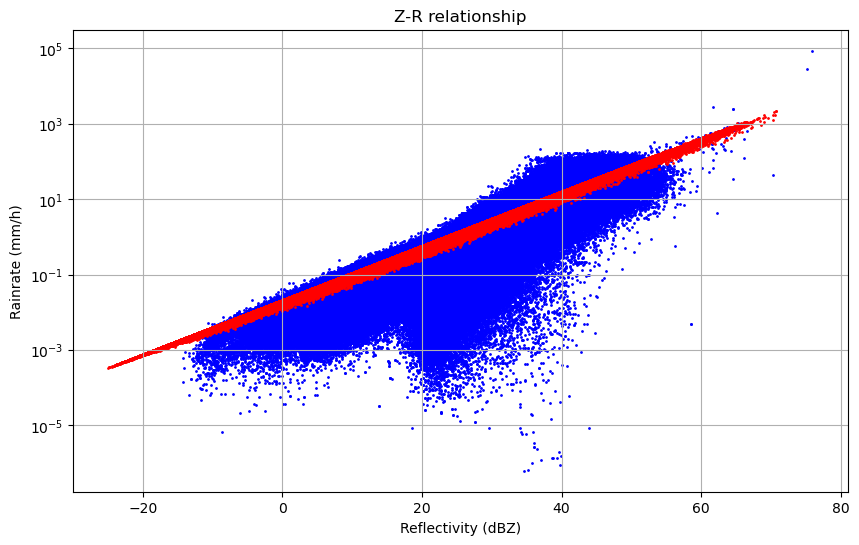

In [64]:
#scatter plot of dbz vs rainrate
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values.flatten(),rainrate2[indexAP:-1,:,:].values.flatten(),s=1,color='blue',label='AP')
plt.scatter(dbz2[0:indexBP,:,:].values.flatten(),rainrate2[0:indexBP,:,:].values.flatten(),s=1,color='red',label='BP')
#plt.legend()
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
#plt.ylim(100,3000)
plt.grid()
plt.title('Z-R relationship')
plt.show()

#plt.savefig('../../figures/Fig_seapol_ZR_scatter.png')

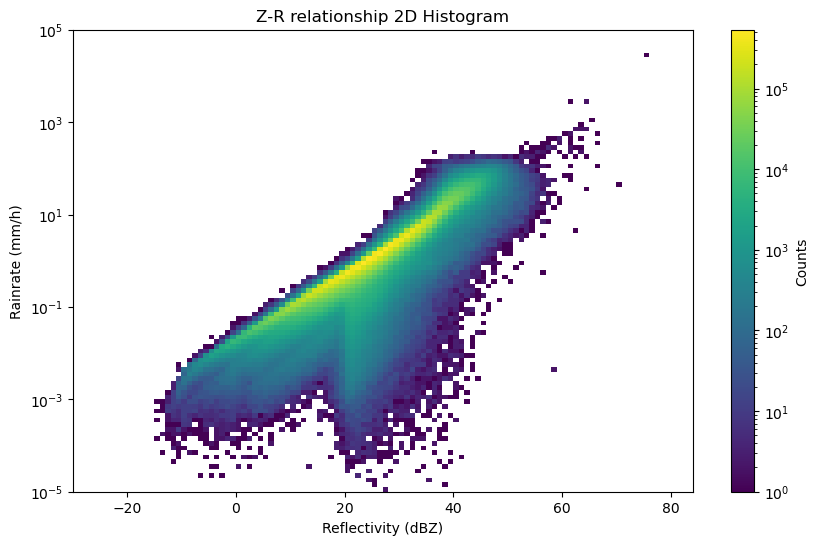

In [ ]:
# Prepare data for 2D histogram
#dbz_flat = dbz2.values.flatten()
#rainrate_flat = rainrate2.values.flatten()
dbz_flat = dbz2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time
rainrate_flat = rainrate2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time

# Filter out NaN values
mask = ~np.isnan(dbz_flat)
dbz_flat_filtered = dbz_flat[mask]
rainrate_flat_filtered = rainrate_flat[mask]

# Calculate 2D histogram
#pbins = np.concatenate((np.arange(0,1e-4,1e-5),np.arange(1e-4,1e-3,1e-4),np.arange(1e-3,0.01,1e-3),np.arange(0.01,0.1,0.01),np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100),np.arange(1000,10000,1000),np.arange(10000,100000,10000)))
pbins = np.concatenate(([0],np.power(10,np.arange(-5,5,0.1))))
dbzbins = np.arange(-30,85,1)
hist, xedges, yedges = np.histogram2d(dbz_flat_filtered, np.transpose(rainrate_flat_filtered), bins=[dbzbins, pbins],range=[[-30, 80], [0, 100000]])

# Plot 2D histogram
plt.figure(figsize=(10,6))
dbzmesh,pmesh = np.meshgrid(xedges, yedges)
plt.pcolormesh(dbzmesh, pmesh, hist.T, norm=LogNorm(), cmap='viridis', shading='auto')
#plt.imshow(hist.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Counts')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(1e-5,1e5)
plt.title('Z-R relationship 2D Histogram')
plt.show()

In [42]:
seapol.time[np.where(rain245 == np.nanmax(rain245))]

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-09-07T14:40:45.632000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-07T14:40:45.632000
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

# Troubleshooting bad data

In [63]:
np.where(seapol.RAINRATE[4319,:,:] == np.nanmax(seapol.RAINRATE[4319,:,:].values))

(array([239]), array([211]))

In [76]:
seapol.DBZ[4319,239,211].values

array(75.95426, dtype=float32)

In [77]:
seapol.DBZ[4319,239,212].values

array(75.11272, dtype=float32)

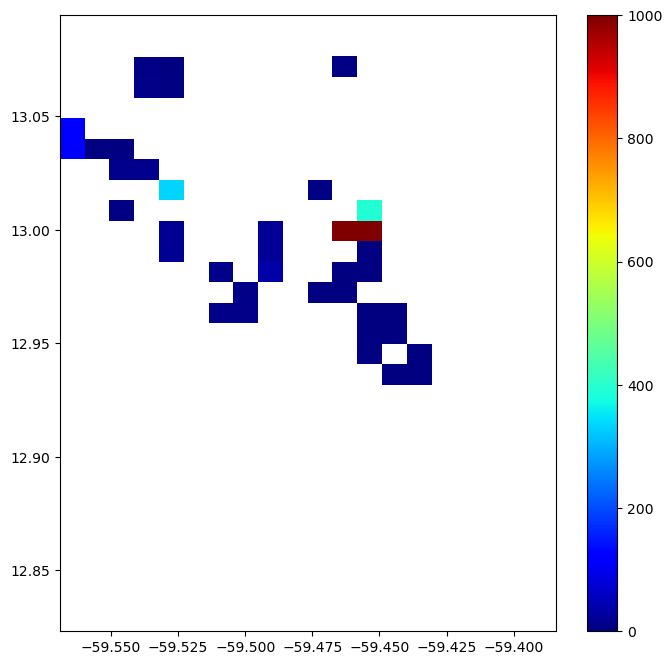

In [65]:
fig.ax = plt.subplots(figsize=(8,8))
plt.pcolormesh(seapol.longitude[4319,220:250,200:220], seapol.latitude[4319,220:250,200:220], seapol.RAINRATE[4319,220:250,200:220], cmap='jet',vmin=0,vmax=1000)
plt.colorbar()

# Plot time series

/tmp/ipykernel_3281120/1917307395.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_3281120/1917307395.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -2.5, '−2.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

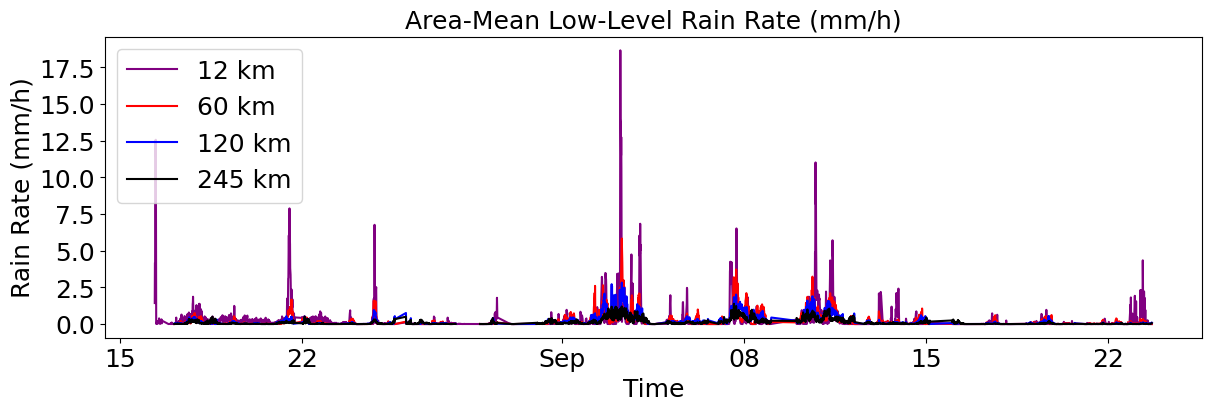

In [13]:
#Plot for whole campaign (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time, rain12, color='purple', label='12 km')
ax.plot(seapol.time, rain60, color='red', label='60 km')
ax.plot(seapol.time, rain120, color='blue', label='120 km')
ax.plot(seapol.time, rain245, color='black', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

#ax.set_ylim(0, 4)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_3281120/2045524149.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_3281120/2045524149.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -50.0, '−50'),
 Text(0, 0.0, '0'),
 Text(0, 50.0, '50'),
 Text(0, 100.0, '100'),
 Text(0, 150.0, '150'),
 Text(0, 200.0, '200'),
 Text(0, 250.0, '250'),
 Text(0, 300.0, '300')]

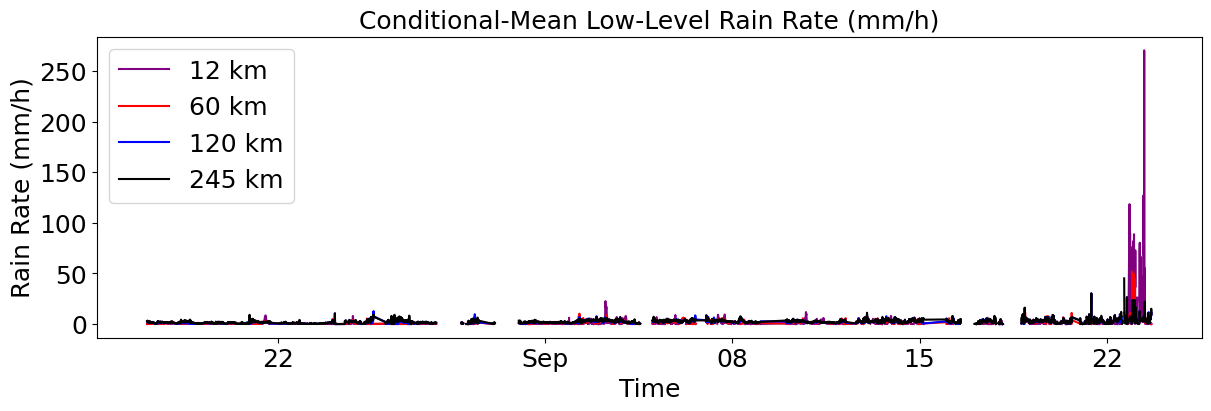

In [16]:
#Plot rain intensity (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time, rain12cond, color='purple', label='12 km')
ax.plot(seapol.time, rain60cond, color='red', label='60 km')
ax.plot(seapol.time, rain120cond, color='blue', label='120 km')
ax.plot(seapol.time, rain245cond, color='black', label='245 km')
ax.set_title('Conditional-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_3281120/4018549413.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_3281120/4018549413.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -2.5, '−2.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

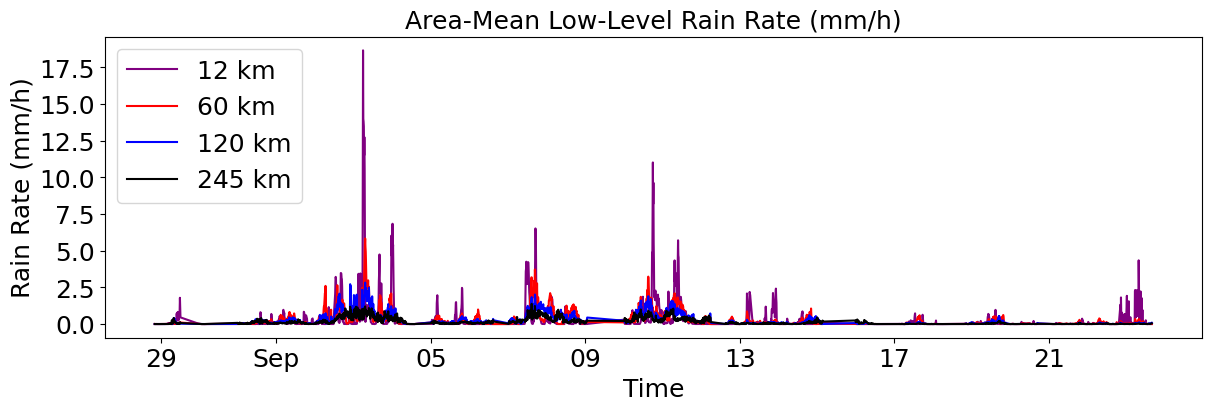

In [17]:
#Plot for AP period (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time[indexAP:-1], rain12[indexAP:-1], color='purple', label='12 km')
ax.plot(seapol.time[indexAP:-1], rain60[indexAP:-1], color='red', label='60 km')
ax.plot(seapol.time[indexAP:-1], rain120[indexAP:-1], color='blue', label='120 km')
ax.plot(seapol.time[indexAP:-1], rain245[indexAP:-1], color='black', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_3281120/3680491117.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_3281120/3680491117.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -50.0, '−50'),
 Text(0, 0.0, '0'),
 Text(0, 50.0, '50'),
 Text(0, 100.0, '100'),
 Text(0, 150.0, '150'),
 Text(0, 200.0, '200'),
 Text(0, 250.0, '250'),
 Text(0, 300.0, '300')]

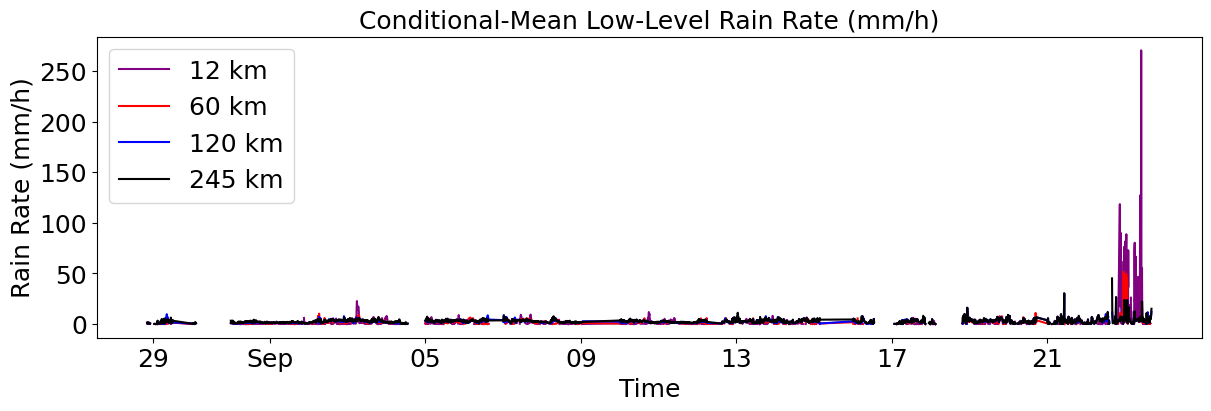

In [18]:
#Plot rain intensity for AP period (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time[indexAP:-1], rain12cond[indexAP:-1], color='purple', label='12 km')
ax.plot(seapol.time[indexAP:-1], rain60cond[indexAP:-1], color='red', label='60 km')
ax.plot(seapol.time[indexAP:-1], rain120cond[indexAP:-1], color='blue', label='120 km')
ax.plot(seapol.time[indexAP:-1], rain245cond[indexAP:-1], color='black', label='245 km')
ax.set_title('Conditional-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_973230/2585862992.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_973230/2585862992.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0')]

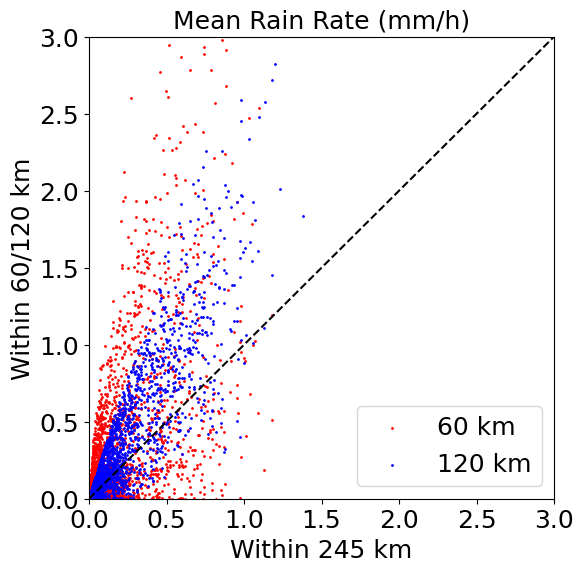

In [52]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245[indexAP:-1], rain60[indexAP:-1],s=1,color='red',label='60 km')
ax.scatter(rain245[indexAP:-1], rain120[indexAP:-1],s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 3, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)
ax.set_title('Mean Rain Rate (mm/h)', fontsize=18)

ax.set_xlim(0,3)
ax.set_ylim(0,3)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


/tmp/ipykernel_973230/3731360174.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_973230/3731360174.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0'),
 Text(0, 5.0, '5'),
 Text(0, 10.0, '10'),
 Text(0, 15.0, '15'),
 Text(0, 20.0, '20'),
 Text(0, 25.0, '25'),
 Text(0, 30.0, '30')]

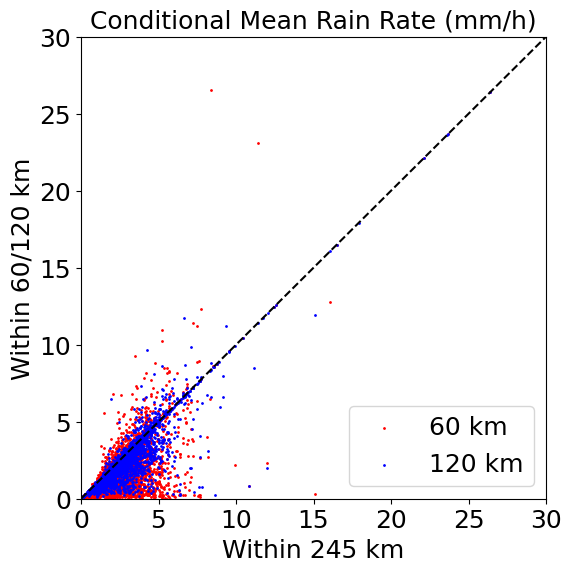

In [53]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245cond[indexAP:-1], rain60cond[indexAP:-1],s=1,color='red',label='60 km')
ax.scatter(rain245cond[indexAP:-1], rain120cond[indexAP:-1],s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 30, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)

ax.set_title('Conditional Mean Rain Rate (mm/h)', fontsize=18)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# More data troublshooting

In [54]:
# Search times
time1 = np.datetime64('2024-09-21T18:00:00')
time2 = np.datetime64('2024-09-21T18:30:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(seapol.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(seapol.time) - time2).argmin()

/tmp/ipykernel_2731717/618504414.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/618504414.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.2, '−0.2'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4000000000000001, '0.4'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0000000000000002, '1.0'),
 Text(0, 1.2000000000000002, '1.2')]

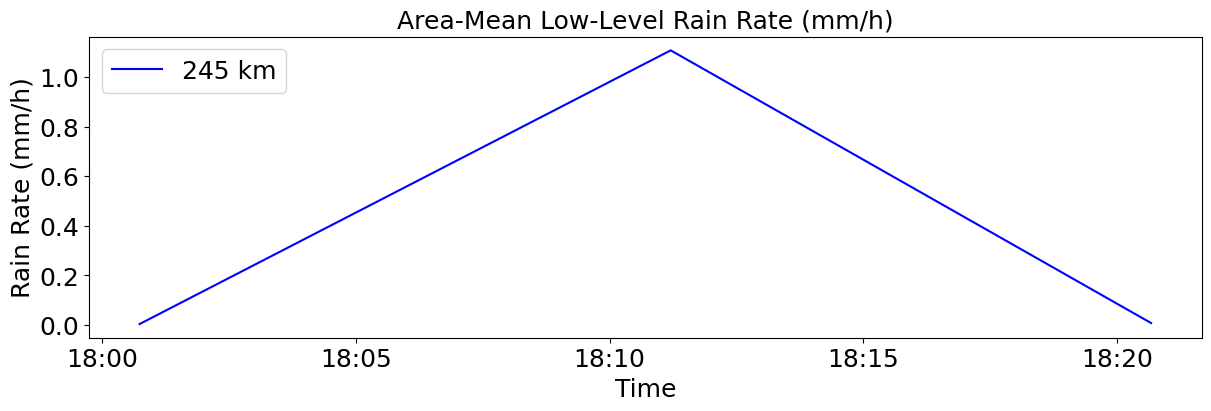

In [82]:
#Plot time series

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(seapol.time[index1:index2], rain245[index1:index2], color='blue', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

In [86]:
seapol.time[index1:index2]

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2024-09-21T18:00:44.263000064', '2024-09-21T18:11:12.288000000',
       '2024-09-21T18:20:40.372000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2024-09-21T18:00:44.263000064 ... 2024...
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

In [91]:
index1

np.int64(4173)

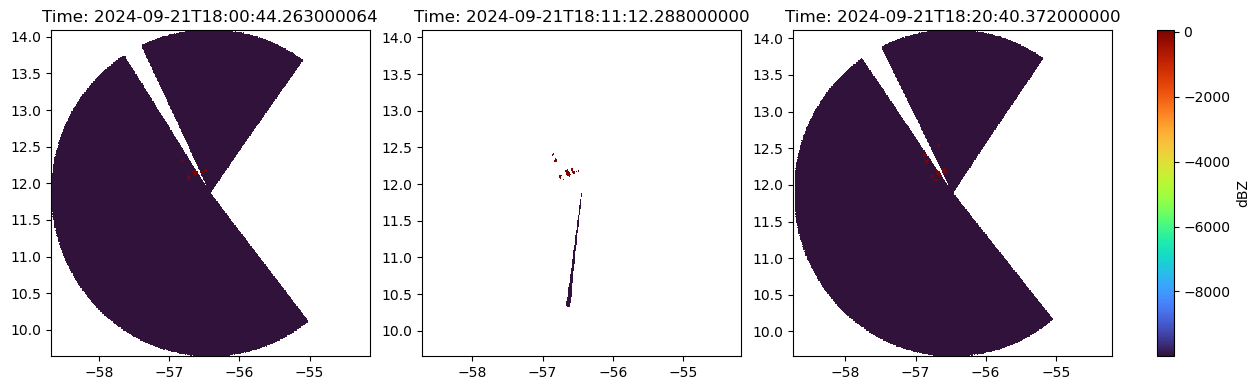

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

#axes[0,0].pcolormesh(seapol.longitude[4173,250:310,180:260], seapol.latitude[4173,250:310,180:260], rainrate4[4173,250:310,180:260], cmap='turbo')
#axes[0,1].pcolormesh(seapol.longitude[4174,250:310,180:260], seapol.latitude[4174,250:310,180:260], rainrate4[4174,250:310,180:260], cmap='turbo')
axes[0].pcolormesh(seapol.longitude[4173,:,:], seapol.latitude[4173,:,:], seapol.DBZ[4173,:,:], cmap='turbo')
axes[1].pcolormesh(seapol.longitude[4174,:,:], seapol.latitude[4174,:,:], seapol.DBZ[4174,:,:], cmap='turbo')
axes[2].pcolormesh(seapol.longitude[4175,:,:], seapol.latitude[4175,:,:], seapol.DBZ[4175,:,:], cmap='turbo')

axes[0].set_title(f'Time: {seapol.time[4173].values}', fontsize=12)
axes[1].set_title(f'Time: {seapol.time[4174].values}', fontsize=12) 
axes[2].set_title(f'Time: {seapol.time[4175].values}', fontsize=12)

fig.tight_layout()
cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('dBZ')

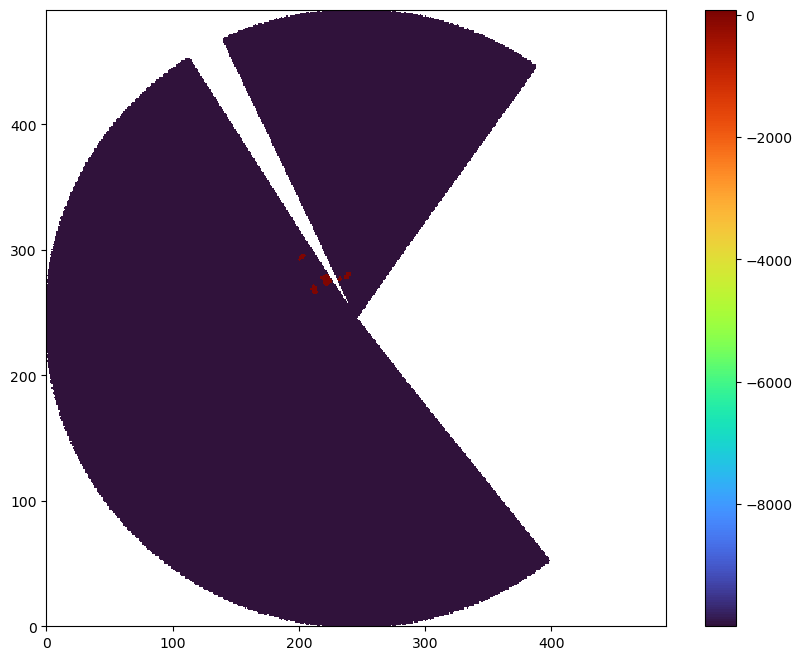

In [23]:
fig,axes = plt.subplots(figsize=(10,8))

#cmap_dbz = mcolors.ListedColormap(['white'] + list(plt.cm.get_cmap('radar.reflectivity')(np.linspace(0, 1, 256))))
#cmap_dbz.set_bad('silver')
#bounds = [-9999, -100, 60]

plt.pcolormesh(seapol.RAINRATE[4173,:,:], cmap='turbo')
plt.colorbar()

In [32]:
seapol.RAINRATE[4173,350,100].values 

array(-9999., dtype=float32)

In [31]:
seapol.RAINRATE[4174,350,100].values

array(nan, dtype=float32)

# Extracting time series at specific times

In [38]:
rain = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means.nc')
rain

<xarray.Dataset> Size: 178kB
Dimensions:       (time: 4447)
Coordinates:
  * time          (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192 .....
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4a Gridded Rain Rate
    units:        mm/h

In [76]:
# Search times
time1 = np.datetime64('2024-09-11T07:50:00')
time2 = np.datetime64('2024-09-11T10:50:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()

/tmp/ipykernel_2281194/466232179.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2281194/466232179.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_2281194/466232179.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


[Text(1, 0.0, '0'),
 Text(1, 2.0, '2'),
 Text(1, 4.0, '4'),
 Text(1, 6.0, '6'),
 Text(1, 8.0, '8'),
 Text(1, 10.0, '10'),
 Text(1, 12.0, '12'),
 Text(1, 14.0, '14'),
 Text(1, 16.0, '16')]

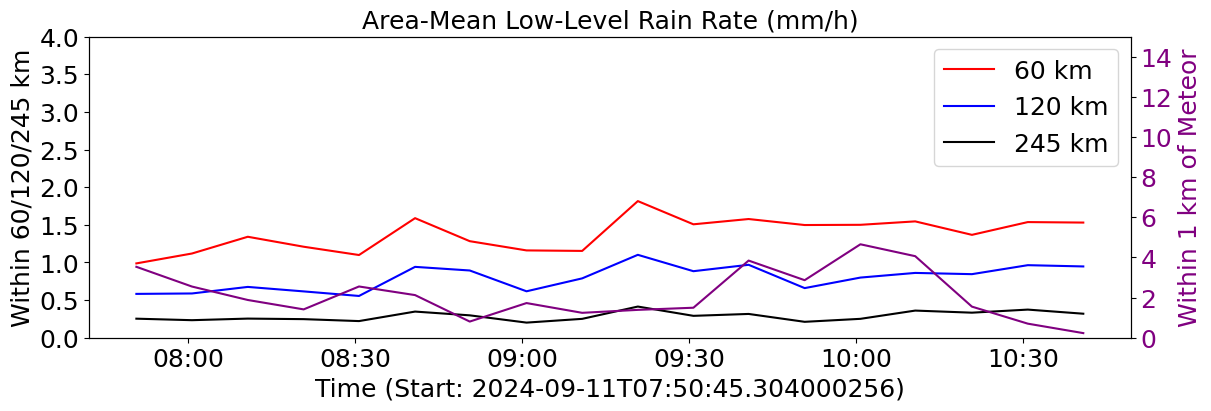

In [77]:
# make plot
fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='red', label='60 km')
ax.plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', label='120 km')
ax.plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='black', label='245 km')

ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Within 60/120/245 km', fontsize=18)
ax.set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
ax.set_ylim(0, 4)

ax.legend(loc='upper right', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax2 = ax.twinx()
ax2.plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='purple', label='1 km')
ax2.set_ylim(0,15)
ax2.set_ylabel('Within 1 km of Meteor',color='purple',fontsize=18)
ax2.tick_params(axis='y',labelcolor='purple')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)

# Time series for specific time period

In [57]:
# Search times
time1 = np.datetime64('2024-09-08T08:00:00')
time2 = np.datetime64('2024-09-08T14:00:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()

Add disdrometer data

In [58]:
disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')

#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == time1)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == time2)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with a running mean, restrict to the time period of interest
disdro_p = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=10, center=True).mean() # 10 minute running mean
disdro

<xarray.Dataset> Size: 255MB
Dimensions:                       (time: 56160, particle_size: 32,
                                   raw_fall_velocity: 32)
Coordinates:
  * time                          (time) datetime64[ns] 449kB 2024-08-16 ... ...
  * particle_size                 (particle_size) float32 128B 0.062 ... 24.5
  * raw_fall_velocity             (raw_fall_velocity) float32 128B 0.05 ... 20.8
Data variables: (12/45)
    missing_data_flag             (time) int32 225kB ...
    lon                           (time) float32 225kB ...
    lat                           (time) float32 225kB ...
    hgt                           (time) float32 225kB ...
    qc_number_detected_particles  (time) float32 225kB ...
    qc_spectrum                   (time, raw_fall_velocity, particle_size) float32 230MB ...
    ...                            ...
    delta_co_x                    (time) float32 225kB ...
    kdp_x                         (time) float32 225kB ...
    ai_x                          (time) float32 225kB ...
    adr_x                         (time) float32 225kB ...
    conv_strat                    (time) float32 225kB ...
    greatest_RR_flag              (time) float64 449kB ...
Attributes: (12/23)
    title:                           Merged PARSIVEL Disdrometer QCed data
    summary:                         The merged version contains data from th...
    creator_name:                    Delián Colón-Burgos
    creator_email:                   delianb@colostate.edu
    project:                         ['ORCESTRA', 'BOW-TIE', 'PICCOLO']
    platform:                        RV METEOR
    ...                              ...
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    simulated_s_freq:                2997924580 Hz
    simulated_c_freq:                5995849160 Hz
    simulated_x_freq:                9993081933 Hz

/tmp/ipykernel_1928284/337087979.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1928284/337087979.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_1928284/337087979.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


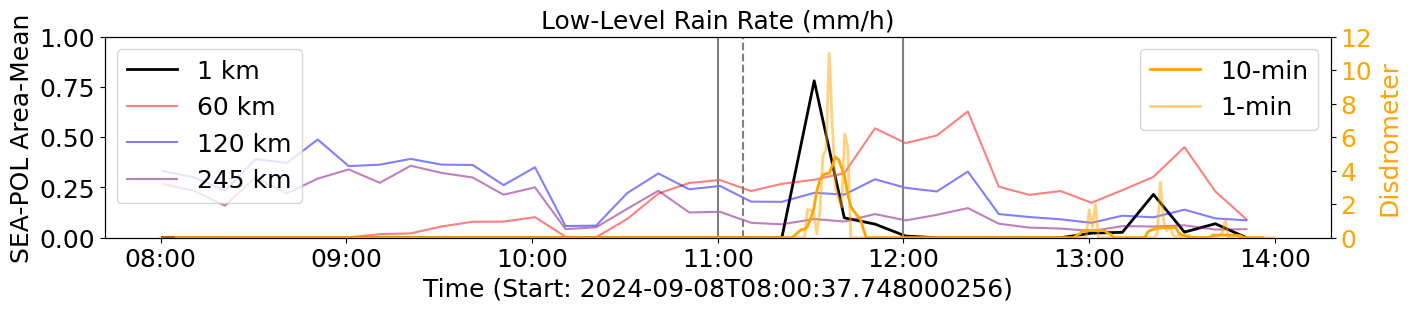

In [68]:
# make plot
fig,ax = plt.subplots(figsize=(14,3),layout="constrained")
ax.plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='black', label='1 km',linewidth=2)
ax.plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='red', alpha=0.5, label='60 km')
ax.plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', alpha=0.5, label='120 km')
ax.plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='purple', alpha=0.5, label='245 km')

#vertical lines at specific times
ax.axvline(x=pd.to_datetime('2024-09-08T11:00:00'), color='gray', linestyle='-')
ax.axvline(x=pd.to_datetime('2024-09-08T11:08:00'), color='gray', linestyle='--')
ax.axvline(x=pd.to_datetime('2024-09-08T12:00:00'), color='gray', linestyle='-')

ax.set_title('Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('SEA-POL Area-Mean', fontsize=18)
ax.set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
ax.set_ylim(0, 2)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax2 = ax.twinx()
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro_p.values, color='orange', linewidth=2,label='10-min')
ax2.plot(disdro.time[index_start_disdro:index_end_disdro+1], disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].values, color='orange', alpha=0.5, linewidth=2,label='1-min')
ax2.set_ylim(0,12)
ax2.set_ylabel('Disdrometer',color='orange',fontsize=18)
ax2.tick_params(axis='y',labelcolor='orange')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)
ax2.legend(loc='upper right', fontsize=18)
